# Игры - Анализ рекламных источников.

[Презентация](https://disk.yandex.ru/i/AYk2rngFPpjBsg)

Задача: Анализ поведения игроков в зависимости от источника перехода

**Описание датасетов:**

Основной датасет содержит данные о событиях, совершенных в мобильной игре «Космические братья». В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики.

Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

В датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:

- Победа над первым врагом
- Реализация проекта - разработка орбитальной сборки спутников

В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

Датасет *game_actions.csv*:

- `event_datetime` — время события;
- `event` — одно из трёх событий:
    1. `building` — объект построен,
    2. `finished_stage_1` — первый уровень завершён,
    3. `project` — проект завершён;
- `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;
- `user_id` — идентификатор пользователя;
- `project_type` — тип реализованного проекта;

Помимо основного датасета есть два датасета с информацией о рекламных активностях. Они также помогут в решении задачи.

Датасет *ad_costs.csv*:

- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов

Датасет user_source.csv содержит колонки:

- `user_id` - идентификатор пользователя
- `source` - источников, с которого пришёл пользователь, установивший приложение

**Таким образом, исследование пройдёт в несколько этапов:**

**Шаг 1. Знакомство с данными**

- Обзор данных
- Предобработка данных

**Шаг 2. Исследовательский анализ данных**

- Общий анализ представленных данных из всех доступны таблиц.
- Узнать распределение событий
   - по дням
   - по типу
- Распределение построек по типу
- Распределение игроков по каналам привлечения
- Просмотреть группы завершившийх и незавершивших уровень.
- Расчёт стоимости привлечения игрока по разным каналам привлечения

**Анализ влияния источника перехода в игру на поведение пользователя**

- Динамика количества пользователей 
- Посчитать для каждого пользователя время, потраченное на прохождение первого уровня
- Поведение игроков в зависимости от источника
- Способы прохождения уровня в зависимости от источника

**Шаг 3. Статистические гипотезы**

- Проверьте гипотезу: *время завершения уровня различается в зависимости способа прохождения*:
  - через реализацию проекта,
  - через победу над первым врагом.
- Рассчитать среднее время завершения и оценить распределение времени завершения в группе завершивших через разные способы прохождения первого уровня
- при распределении близком к нормальному использовать t-тест для непарных выборок, при ненормальном распределении использовать критерий Манна-Уитни;

- Проверьте гипотезу: *доля игроков завершивших первый уровень различается в зависимости от канала привлечения*
- выбрать уровень статистической значимости с поправкой Бонферрони
- сравнить ранее рассчитанные доли игроков завершивших первый уровень в разных каналах привлечения, используя z-тест;


In [1]:
pip install matplotlib --upgrade

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
from scipy import stats as st
import math as mth

In [3]:
pip install -U kaleido

     |████████████████████████████████| 79.9 MB 72 kB/s s eta 0:00:01     |██████████▏                     | 25.5 MB 2.7 MB/s eta 0:00:21     |██████████████████████████████▊ | 76.8 MB 17.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import plotly.io as pio
pio.renderers.default = "png"

## Знакомство с данными

### Обзор данных и предобработка

In [5]:
ad_costs = pd.read_csv('/datasets/ad_costs.csv')
game_actions = pd.read_csv('/datasets/game_actions.csv')
user_source = pd.read_csv('/datasets/user_source.csv')

In [6]:
def information(df):
    print(df.head(3))
    print(df.info())
    print('Количество дубликатов:', df.duplicated().sum())
    print('Количество пропусков:')
    display(df.isna().sum())

In [7]:
information(ad_costs)

         source         day        cost
0  facebook_ads  2020-05-03  935.882786
1  facebook_ads  2020-05-04  548.354480
2  facebook_ads  2020-05-05  260.185754
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes
None
Количество дубликатов: 0
Количество пропусков:


source    0
day       0
cost      0
dtype: int64

В датафрейме с данными о стоимости рекламы по дням и каналам пропущенные значения и дубликаты отсутствуют. 28 строк и 3 столбца.

In [8]:
information(game_actions)

        event_datetime     event  building_type  \
0  2020-05-04 00:00:01  building  assembly_shop   
1  2020-05-04 00:00:03  building  assembly_shop   
2  2020-05-04 00:00:16  building  assembly_shop   

                                user_id project_type  
0  55e92310-cb8e-4754-b622-597e124b03de          NaN  
1  c07b1c10-f477-44dc-81dc-ec82254b1347          NaN  
2  6edd42cc-e753-4ff6-a947-2107cd560710          NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB
None
Количество дубликатов: 1
Количество пропусков:


event_datetime         0
event                  0
building_type       7683
user_id                0
project_type      133774
dtype: int64

Столбец с датой и временем приведем к правильному типу datetime:

In [9]:
game_actions['event_datetime']=pd.to_datetime(game_actions['event_datetime'])

In [10]:
pd.DataFrame(round(game_actions.isna().mean()*100)).style.background_gradient('coolwarm')

,0
event_datetime,0.000000
event,0.000000
building_type,6.000000
user_id,0.000000
project_type,99.000000


Датафрейм, содержащий данные о действиях игроков содержит 135640 строк и 5 столбцов. В нем присутствуют пропуски.

Количество пропусков в столбце building_type -  6%, вероятно эти пропуски соответствуют строкам в которых отражено событие-прохождение первого уровня одним из доступных способов, и обрабатывать данные пропуски не нужно.

Столбец project_type — тип реализованного проект содержит 99% пропусков. В данном столбце ячейка заполняется только в том случае, если первый уровень пройден путём завершения проекта. Обрабатывать пропуски тут не будем

Также в датафрейме присутствует один дубликат, который можно просто удалить.

Проверим пропуски в `building_type` 

In [11]:
game_actions[game_actions['building_type'].isna()]['event'].value_counts().reset_index()

,index,event
0,finished_stage_1,5817
1,project,1866


Пропуски в этом столбце соответствуют строкам в которых отражено событие-прохождение первого уровня одним из доступных способов. Никакого типа здания там не построено. Аномальные пропуски в столбце building_type отсутствуют. 


Проверим пропуски в `project_type` 

In [12]:
game_actions[~(game_actions['project_type'].isna())]['event'].value_counts()

project    1866
Name: event, dtype: int64

В этом столбце ячейка заполняется только, там где способ прохождения 1 уровня - создание проекта. 

Ошибочные пропуски отсутсвуют

In [13]:
game_actions = game_actions.drop_duplicates().reset_index(drop=True)

In [14]:
information(user_source)

                                user_id                   source
0  0001f83c-c6ac-4621-b7f0-8a28b283ac30             facebook_ads
1  00151b4f-ba38-44a8-a650-d7cf130a0105            yandex_direct
2  001aaea6-3d14-43f1-8ca8-7f48820f17aa  youtube_channel_reklama
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB
None
Количество дубликатов: 0
Количество пропусков:


user_id    0
source     0
dtype: int64

В датасете с каналами прихода игроков 2 столбца и 13576 строк, дубликаты и пропуски отсутствуют.

**Промежуточный вывод:** В датафреймах с данными о рекламе и каналах привлечения клиентов отсутствуют дубликаты и пропуски.
Датасет с информацией об активностях игроков содержит 6% пропусков в столбце building_type и 99% пропусков в столбце project_type, пропуски не требуют обработки. Также датафрейм содержал 1 дубликат который был удалён. В столбце с датой и временем события формат object был заменен на datetime.
В датасете с каналами прихода игроков дубликаты и пропуски отсутствуют.


##  Исследовательский анализ данных

### Распределение событий по дням

In [15]:
game_actions['event_date'] = game_actions['event_datetime'].dt.date

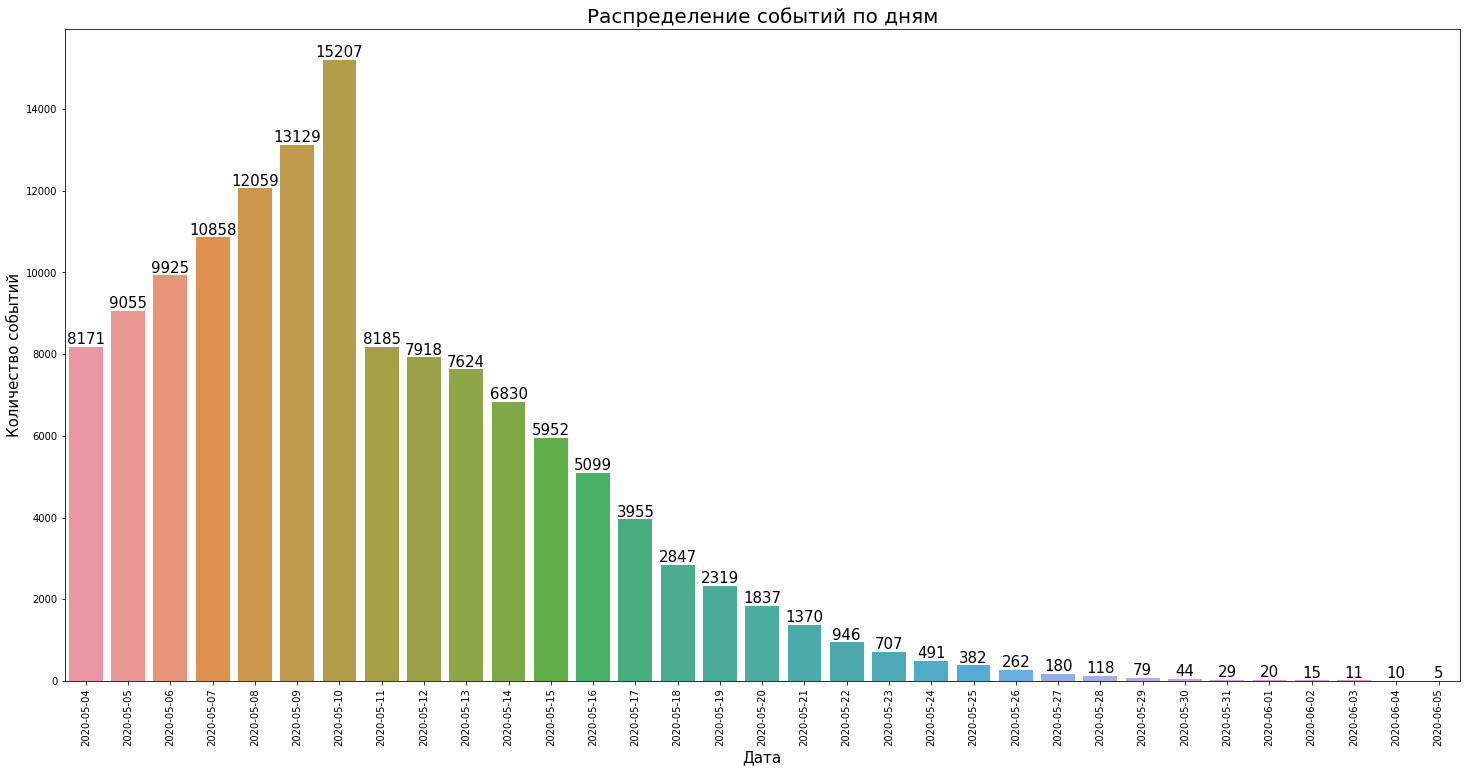

In [16]:
plt.figure(figsize=(25, 12))
plt.title('Распределение событий по дням', fontsize=20)
ax = sns.barplot(x=game_actions.groupby('event_date').agg({'event' : 'count'}).index, 
            y=game_actions.groupby('event_date').agg({'event' : 'count'})['event'])
ax.bar_label(ax.containers[0], fontsize=15)
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Количество событий', fontsize=15)
plt.xticks(rotation=90)
plt.show()

Количество событий растёт с 4.05 по 10.05 , 11.05 количество событий резко снижается и продолжает ежедневно снижаться (5.06 количество событий составило всего 5). Т.е. наибольшую активность пользователи проявляют в течении нескольких дней после привлечения

### Распределение событий по типу

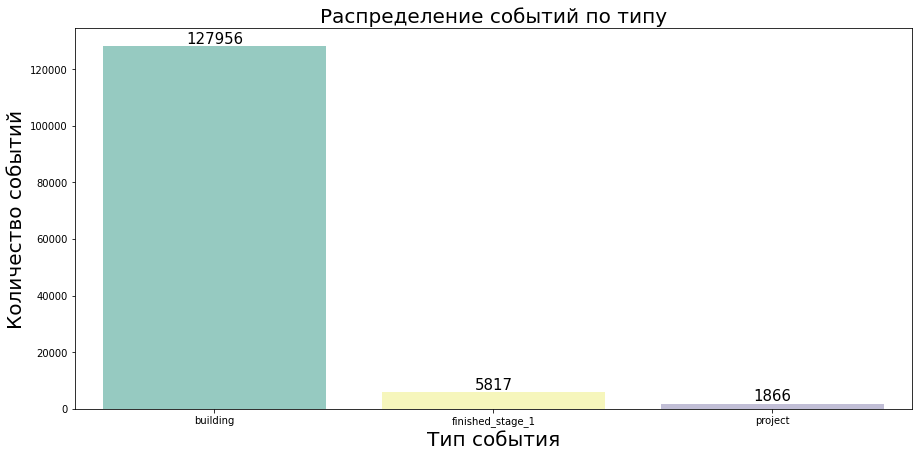

In [17]:
plt.figure(figsize=(15, 7))
a = sns.barplot( x=game_actions.groupby('event').agg({'user_id' : 'count'}).index, 
            y=game_actions.groupby('event').agg({'user_id' : 'count'})['user_id'], palette='Set3')
a.bar_label(a.containers[0], fontsize=15)
a.set_title('Распределение событий по типу', fontsize=20)
a.set_xlabel('Тип события', fontsize=20)
a.set_ylabel('Количество событий', fontsize=20)

plt.show()

Самое частое событие - это постройка здания ('building'), оно произошло 127956 раз. Вторым по частоте является событие 'final_stage_1', которое означает, что игрок завершил первый уровень через победу над врагом, так первый уровень был завершён 5817 раз. Реже всего происходило событие 'project', завершение уровня через реализацию проекта, данное событие произошло 1866 раз и составляет 1,4% от всех событий.

### Распределение построек по типу

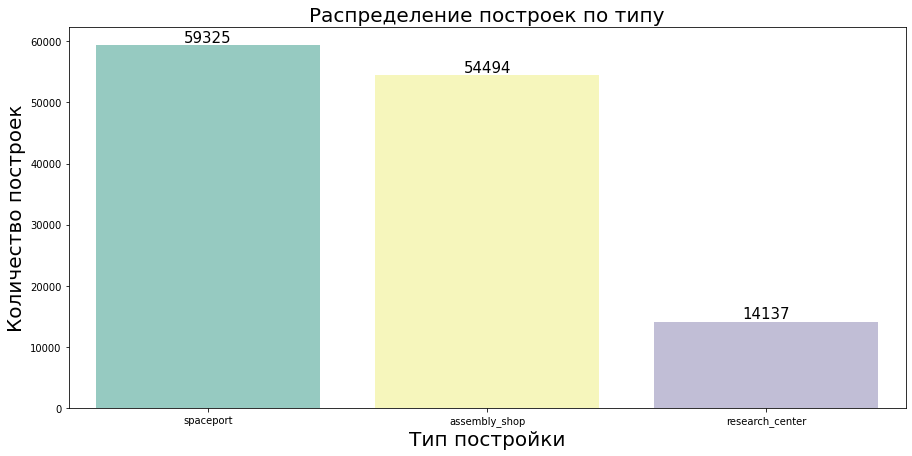

In [18]:
plt.figure(figsize=(15, 7))
a = sns.barplot(x=game_actions.groupby('building_type').agg({'user_id' : 'count'}).sort_values(by='user_id', ascending=False).index, 
            y=game_actions.groupby('building_type').agg({'user_id' : 'count'}).sort_values(by='user_id', ascending=False)['user_id'], palette='Set3')
a.bar_label(a.containers[0], fontsize=15)
a.set_title('Распределение построек по типу', fontsize=20)
a.set_xlabel('Тип постройки', fontsize=20)
a.set_ylabel('Количество построек', fontsize=20)
plt.show()

Чаще всего игроки строят 'spaceport', всего построено 59325 зданий такого типа. На втором месте по популярности у пользователей стоит 'assembly_shop' - 54494. Самая редкая постройка - 'research_center' - её построили всего 14137 раз или 11,0%. Такое распределение может быть связано с тем, что 'research_center' необходимо построить только один раз, а остальные постройки можно возводить по несколько раз. Кроме того, постройка 'research_center' может быть связана с завершением уровня через реализацию проекта, из предыдущего пункта нам известно, что таким образом заканчивают уровень наименьшее количество игроков, то логично, что и постройка данного типа должна быть наименее популярной.

### Распределение игроков по каналам привлечения

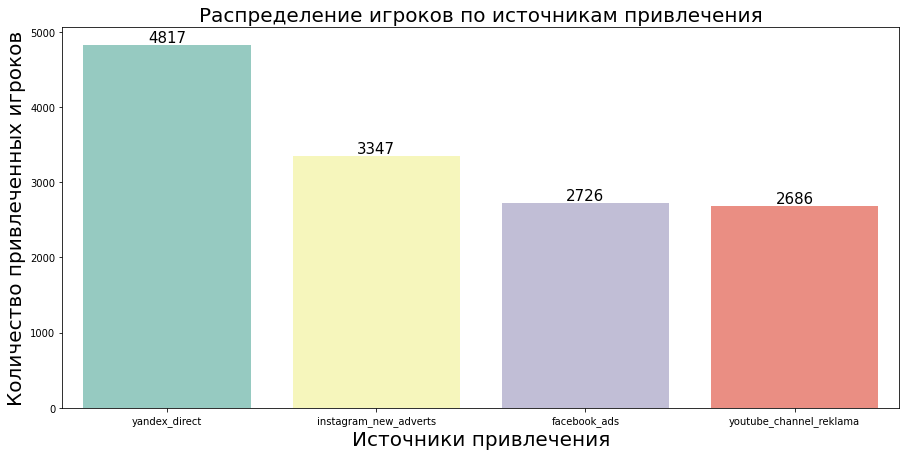

In [19]:
plt.figure(figsize=(15, 7))
a = sns.barplot(x=user_source.groupby('source').agg({'user_id' : 'count'}).sort_values(by='user_id', ascending=False).index, 
            y=user_source.groupby('source').agg({'user_id' : 'count'}).sort_values(by='user_id', ascending=False)['user_id'], palette='Set3')
a.bar_label(a.containers[0], fontsize=15)
a.set_title('Распределение игроков по источникам привлечения', fontsize=20)
a.set_xlabel('Источники привлечения', fontsize=20)
a.set_ylabel('Количество привлеченных игроков', fontsize=20)
plt.show()

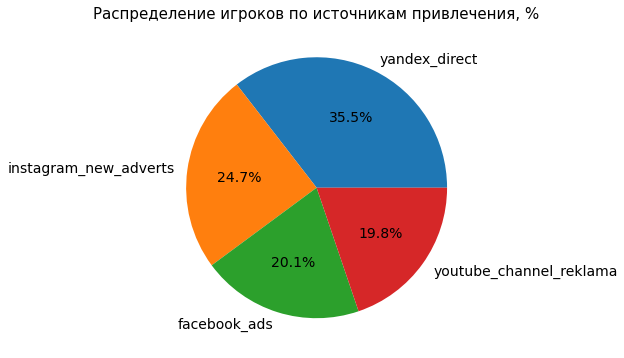

In [20]:
plt.figure(figsize=(8, 6))
plt.title('Распределение игроков по источникам привлечения, %', fontsize=15)
plt.pie(x=user_source.groupby('source').agg({'user_id' : 'count'}).sort_values(by='user_id', ascending=False)['user_id'], 
        labels=user_source.groupby('source').agg({'user_id' : 'count'}).sort_values(by='user_id', ascending=False).index, 
        autopct='%.1f%%', textprops={'fontsize': 14})
plt.show()

По графикам видно, что наибольшая часть игроков пришли через Yandex - их количество 4817 (35,5% от всех игроков). Через Instagram пришло 3347 игроков, 24,7%. Практически одинаковое количество игроков были привлечены через Facebook и Youtube - по 20%

### Расчёт стоимости привлечения игрока через разные источники

Для расчёта CAC необходимо общие затраты на рекламу через определённый канал поделить на количество привлечённых игроков. 

In [21]:
ad_costs = ad_costs.replace({'source' : {'yandex_direct' : 'Yandex', 'instagram_new_adverts' : 'Instagram', 
                                               'facebook_ads' : 'Facebook', 'youtube_channel_reklama' : 'Youtube'}})

In [22]:
user_source = user_source.replace({'source' : {'yandex_direct' : 'Yandex', 'instagram_new_adverts' : 'Instagram', 
                                               'facebook_ads' : 'Facebook', 'youtube_channel_reklama' : 'Youtube'}})

In [23]:
game_actions = game_actions.merge(user_source, on='user_id', how='left')

In [24]:
def cac(data):
    print('САС игроков через {}: {:.2f}'.format(data, (ad_costs[ad_costs['source'] == data]['cost'].sum() / 
                                                      game_actions[game_actions['source'] == data]['user_id'].nunique())))

In [25]:
cac('Yandex')

САС игроков через Yandex: 0.46


In [26]:
cac('Facebook')

САС игроков через Facebook: 0.79


In [27]:
cac('Instagram')

САС игроков через Instagram: 0.65


In [28]:
cac('Youtube')

САС игроков через Youtube: 0.40


Через Facebook привлечение пользователей обходится дороже всего - 0,79 у.е. Немного дешевле через Instagram - 0,65 у.е. Стоимость привлечения игрока через Yandex 0,46 у.е., и самая низкая стоимость привлечения через Youtube - 0,40 у.е.

### Распределение событий

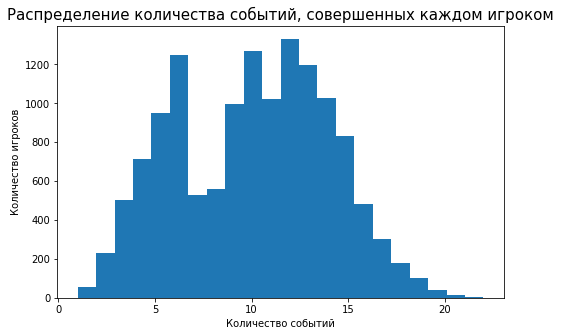

In [29]:
plt.figure(figsize=(8,5))
plt.title('Распределение количества событий, совершенных каждом игроком', fontsize=15)
plt.hist(game_actions.groupby('user_id').agg({'event' : 'count'}), bins=22)
plt.xlabel('Количество событий')
plt.ylabel('Количество игроков')
plt.show()

На гистограмме видно два пика: 5-6 событий и 10-15 событий, совершаемых игроками. Это вне зависимости от каналов привлечения

**Распределение событий в зависимости от канала привлечения:**

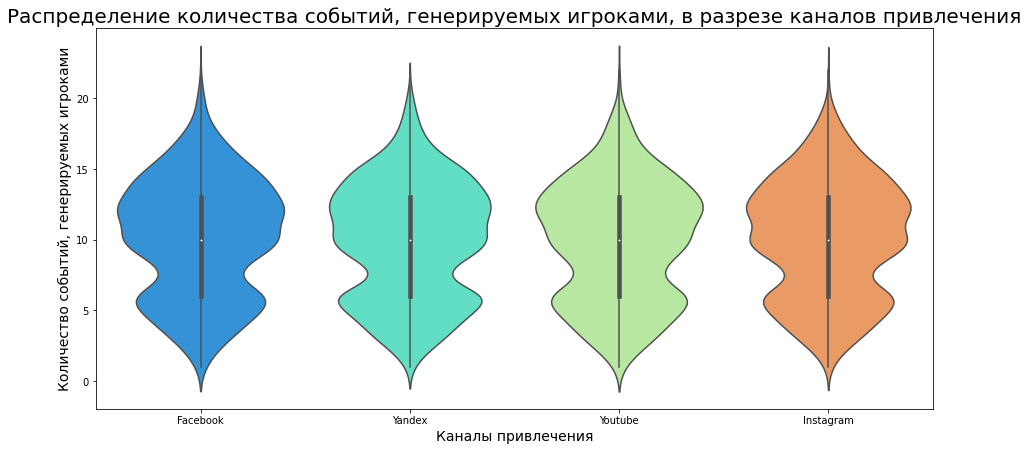

In [30]:
plt.figure(figsize=(15, 7))
ax = sns.violinplot(x='source', y='event', data=game_actions.groupby(['user_id', 'source']).agg({'event' : 'count'}, 
                                                                                       ).reset_index(), palette='rainbow')
ax.set_title('Распределение количества событий, генерируемых игроками, в разрезе каналов привлечения', fontsize=20)
ax.set_ylabel('Количество событий, генерируемых игроками', fontsize=14)
ax.set_xlabel('Каналы привлечения', fontsize=14)
plt.show()

В распределении количества событий, совершаемых игроками, в зависимости от канала привлечения отсутствуют значимые различия. Везде в среднем 10 событий.

### Игроки завершившие первый уровень

Завершение первого уровня требует от игрока выполнения одного из двух условий:

- Победа над первым врагом
- Реализация проекта - разработка орбитальной сборки спутников

In [31]:
users_finish = game_actions.groupby(['user_id', 'source']).agg({'event' : 'unique'}).reset_index()

In [32]:
users_finish

,user_id,source,event
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,Facebook,[building]
1,00151b4f-ba38-44a8-a650-d7cf130a0105,Yandex,[building]
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,Youtube,[building]
3,001d39dc-366c-4021-9604-6a3b9ff01e25,Instagram,"[building, finished_stage_1]"
4,002f508f-67b6-479f-814b-b05f00d4e995,Facebook,[building]
...,...,...,...
13571,ffef4fed-164c-40e1-bde1-3980f76d0fb5,Instagram,"[building, finished_stage_1]"
13572,fffab3da-da0e-4e30-ae62-10d0a2e24a4e,Facebook,[building]
13573,fffb626c-5ab6-47c9-8113-2062a2f18494,Yandex,"[building, finished_stage_1]"
13574,ffff194a-56b7-4c12-860d-3485242ae7f5,Instagram,[building]


Добавим критерий прохождения игроком первого уровня

In [33]:
def event(row): #функция для категоризации
    if 'finished_stage_1' not in row['event']:
        return 'not_finished'
    elif 'finished_stage_1' in row['event'] and 'project' not in row['event']:
        return 'enemy'
    elif 'project' in row['event']:
        return 'project'
    else:
        return ''

In [34]:
users_finish['first_lvl'] = users_finish.apply(event, axis=1)

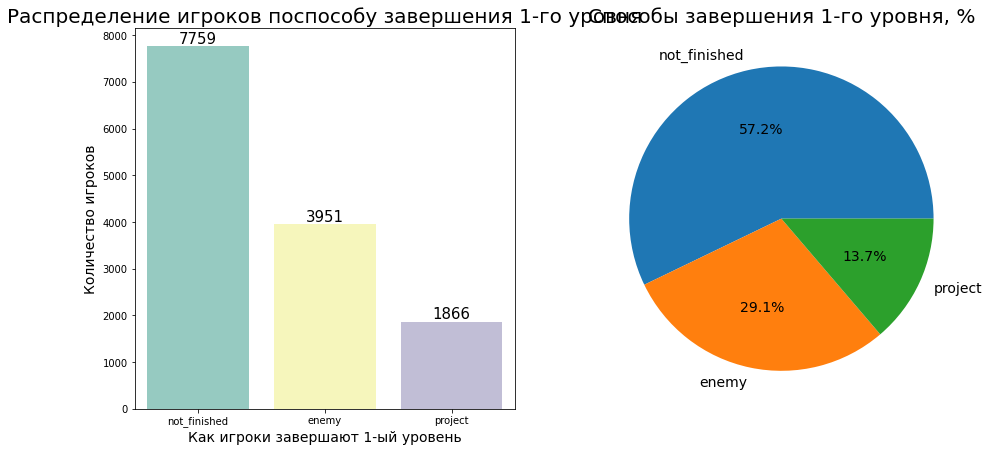

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
a = sns.barplot(ax=ax[0], x=users_finish.groupby('first_lvl').agg({'user_id' : 'count'}).sort_values(by='user_id', ascending=False).index, 
            y=users_finish.groupby('first_lvl').agg({'user_id' : 'count'}).sort_values(by='user_id', ascending=False)['user_id'], palette='Set3')
a.bar_label(a.containers[0], fontsize=15)
a.set_title('Распределение игроков поспособу завершения 1-го уровня', fontsize=20)
a.set_xlabel('Как игроки завершают 1-ый уровень', fontsize=14)
a.set_ylabel('Количество игроков', fontsize=14)

plt.title('Способы завершения 1-го уровня, %', fontsize=20)
plt.pie(x=users_finish.groupby('first_lvl').agg({'user_id' : 'count'}).sort_values(by='user_id', ascending=False)['user_id'], 
        labels=users_finish.groupby('first_lvl').agg({'user_id' : 'count'}).sort_values(by='user_id', ascending=False).index, 
        autopct='%.1f%%', textprops={'fontsize': 14})
plt.show()

Первый уровень был завершён 5817 игроками, что составило 43% от общего количества пользователей. Через победу над первым игроком первый уровень завершил 3951 игрок, а через реализацию проекта 1866 игроков, что составило 29% и 14% от общего количества игроков.

**Теперь посмотрим как игроки завершают уровень в зависимости от канала привлечения**

In [36]:
def fst_lvl(df):
    print(f'Количество игроков, привлеченных через {df} и завершивших первый уровень:', 
          len(users_finish[users_finish['source'] == df].query('first_lvl != "not_finished"'))
         )
    print(f'Количество игроков, привлеченных через {df} и завершивших первый уровень через победу над противником:', 
          len(users_finish[users_finish['source'] == df].query('first_lvl == "enemy"'))
         )
    print('Количество игроков, завершивших первый уровень через реализацию проекта:', 
          len(users_finish[users_finish['source'] == df].query('first_lvl == "project"'))
         )
    print('Доля игроков, завершивших первый уровень, среди привлеченных через {}: {:.0%}'.format(df, 
        len(users_finish[users_finish['source'] == df].query('first_lvl != "not_finished"')) / 
        len(users_finish[users_finish['source'] == df]))
         )

In [37]:
fst_lvl('Youtube')

Количество игроков, привлеченных через Youtube и завершивших первый уровень: 1159
Количество игроков, привлеченных через Youtube и завершивших первый уровень через победу над противником: 780
Количество игроков, завершивших первый уровень через реализацию проекта: 379
Доля игроков, завершивших первый уровень, среди привлеченных через Youtube: 43%


In [38]:
fst_lvl('Facebook')

Количество игроков, привлеченных через Facebook и завершивших первый уровень: 1150
Количество игроков, привлеченных через Facebook и завершивших первый уровень через победу над противником: 759
Количество игроков, завершивших первый уровень через реализацию проекта: 391
Доля игроков, завершивших первый уровень, среди привлеченных через Facebook: 42%


In [39]:
fst_lvl('Instagram')

Количество игроков, привлеченных через Instagram и завершивших первый уровень: 1466
Количество игроков, привлеченных через Instagram и завершивших первый уровень через победу над противником: 990
Количество игроков, завершивших первый уровень через реализацию проекта: 476
Доля игроков, завершивших первый уровень, среди привлеченных через Instagram: 44%


In [40]:
fst_lvl('Yandex')

Количество игроков, привлеченных через Yandex и завершивших первый уровень: 2042
Количество игроков, привлеченных через Yandex и завершивших первый уровень через победу над противником: 1422
Количество игроков, завершивших первый уровень через реализацию проекта: 620
Доля игроков, завершивших первый уровень, среди привлеченных через Yandex: 42%


In [41]:
import plotly.express as px

In [42]:
a=users_finish.groupby(['first_lvl', 'source' ], as_index=False).count()

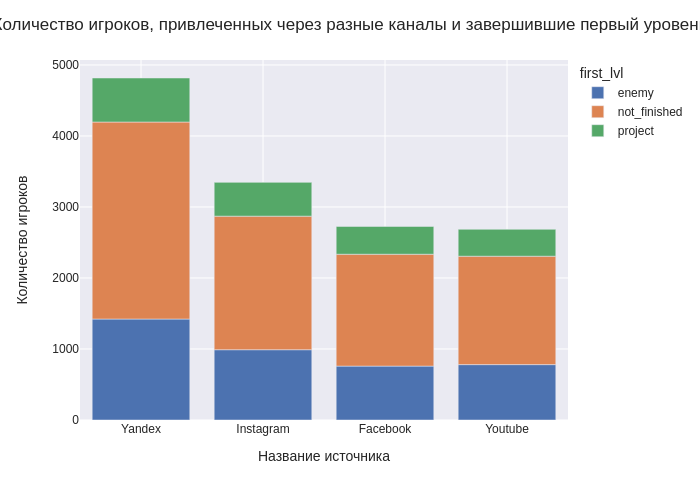

In [43]:
fig = px.bar(a, x='source', y = 'user_id', color='first_lvl', template='seaborn', )
fig.update_layout(title='Количество игроков, привлеченных через разные каналы и завершившие первый уровень',
                   xaxis_title='Название источника',
                   yaxis_title='Количество игроков')
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

Нет явных различий между пользователями, привлеченными из разных источников. Самая высокая доля игроков, завершивших первый уровень - 44% - наблюдается среди игроков, привлеченных через Instagram и Youtube - 43%. Среди игроков, привлеченных через Yandex и Facebook, доля завершивших первый уровень, составляет по 42%. Что очень близко.

**Промежуточный вывод**

Количество событий растёт с 4.05 по 10.05 , 11.05 количество событий резко снижается и продолжает ежедневно снижаться (5.06 количество событий составило всего 5). Т.е. наибольшую ативность пользователи проявляют в течении нескольких дней после привлечения

Самое частое событие - это постройка здания ('building'). Вторым по частоте является событие 'final_stage_1', которое означает, что игрок завершил первый уровень через победу над врагом. Реже всего происходило событие 'project', завершение уровня через реализацию проекта.

Чаще всего игроки строят 'spaceport'. На втором месте по популярности у пользователей стоит 'assembly_shop'. Самая редкая постройка - 'research_center'. Такое распределение может быть связано с тем, что 'research_center' необходимо построить только один раз, а остальные постройки можно возводить по несколько раз. Кроме того, постройка 'research_center' может быть связана с завершением уровня через реализацию проекта, из предыдущего пункта нам известно, что таким образом заканчивают уровень наименьшее количество игроков, то логично, что и постройка данного типа должна быть наименее популярной.


Также мы посмотрели на поведение игроков в зависимости от источника привлечения и сделали выводы:

- наибольшая часть игроков пришли через Yandex - их количество 4817 (35,5% от всех игроков). Через Instagram пришло 24,7%. Практически одинаковое количество игроков были привлечены через Facebook и Youtube - по 20%

- среднее количество событий генерируемых игроками в зависимости от канала привлечения существенно не различается

- доли игроков завершивших первый уровень, практически идентичны показателям доли завершивших первый уровень 42-44%

Через Facebook привлечение пользователей обходится дороже всего - 0,79 у.е. Немного дешевле через Instagram - 0,65 у.е. Стоимость привлечения игрока через Yandex 0,46 у.е., и самая низкая стоимость привлечения через Youtube - 0,40 у.е.

## Статистические гипотезы

### "Время завершения уровня различается в зависимости от способа прохождения"

Посчитаем для каждого пользователя время, потраченное на прохождение первого уровня

In [44]:
game_actions = game_actions.merge(users_finish[['user_id', 'first_lvl']], on='user_id', how='left') 

In [45]:
print('Среднее количество дней, затраченных на завершение 1-ого уровня:', (game_actions.query(
    'first_lvl != "not_finished"').groupby('user_id').agg({'event_datetime' : 'max'})['event_datetime'] - 
    game_actions.query('first_lvl != "not_finished"').groupby('user_id').agg(
        {'event_datetime' : 'min'})['event_datetime']).mean().round('1d').days)



Среднее количество дней, затраченных на завершение 1-ого уровня: 12


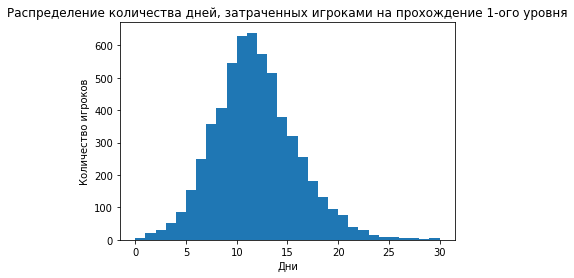

In [46]:
plt.hist((game_actions.query('first_lvl != "not_finished"').groupby('user_id').agg(
    {'event_datetime' : 'max'})['event_datetime'] - game_actions.query('first_lvl != "not_finished"').groupby(
    'user_id').agg({'event_datetime' : 'min'})['event_datetime']).apply(lambda x: x.days), bins=30)
plt.title('Распределение количества дней, затраченных игроками на прохождение 1-ого уровня')
plt.ylabel('Количество игроков')
plt.xlabel('Дни')
plt.show()

В среднем на прохождение 1-ого уровня игроками затрачивается 12 дней, распределение значений показателя близко к нормальному, поэтому для проверки статистической гипотезыможно использовать t-критерий Стьюдента. 

сформулируем нулевую и альтернативную гипотезы:

Н0: "Среднее время завершения уровня не различается в зависимости от способа прохождения".

Н1: "Среднее время завершения уровня различается в зависимости от способа прохождения".

In [47]:
#дни, затраченные игроками на завершение 1-ого уровня через победу над противником
days_enemy = (game_actions.query('first_lvl == "enemy"').groupby('user_id').agg(
    {'event_datetime' : 'max'})['event_datetime'] - game_actions.query('first_lvl == "enemy"').groupby('user_id').agg(
          {'event_datetime' : 'min'})['event_datetime']).round('1d').apply(lambda x: x.days)

#дни, затраченные игроками на завершение 1-ого уровня через реализацию проекта
days_project = (game_actions.query('first_lvl == "project"').groupby('user_id').agg(
    {'event_datetime' : 'max'})['event_datetime'] - game_actions.query('first_lvl == "project"').groupby('user_id').agg(
          {'event_datetime' : 'min'})['event_datetime']).round('1d').apply(lambda x: x.days)
alpha = 0.05 #критический уровень статистической значимости

results = st.ttest_ind(days_enemy, days_project, equal_var=False)

print('Среднее количество дней, затраченных на завершение 1-ого уровня через победу над противником: {:.0f}'.format(
    days_enemy.mean())
     )
print('Среднее количество дней, затраченных на завершение 1-ого уровня через реализацию проекта: {:.0f}'.format(
    days_project.mean())
     )
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Нулевая гипотеза отвергнута')
else:
    print('Нельзя отвергнуть нулевую гипотезу')

Среднее количество дней, затраченных на завершение 1-ого уровня через победу над противником: 11
Среднее количество дней, затраченных на завершение 1-ого уровня через реализацию проекта: 13
p-значение:  1.0867598832876934e-106
Нулевая гипотеза отвергнута


Игроки завершающие уровень через победу над врагом тратят на это в среднем 11 дней, а игроки реализующие проект - 13 дней.

### "Доля игроков завершивших первый уровень различается в зависимости от канала привлечения"

Используем z-тест для сравнения долей в каждой группе игроков, привлеченных из разных источников. Доля игроков Yandex и Facebook, завершивших 1-ый уровень составляет по 42%, поэтому не будем их сравнивать. Необходимо учесть, что мы будем проводить множественные сравнения, а значит нужно сделать поправку критического уровня статистической значимости, для чего используем поправку Бонферрони.

Н0: "Доли игроков заврешивших первый уровень не различаются в разных каналах привлечения". 

Н1: "Доли игроков заврешивших первый уровень различаются в разных каналах привлечения".

In [48]:
def z_test(x1, n1, x2, n2):
    
    bonferroni_alpha = .05/6 #критический уровень статистической значимости c поправкой Бонферрони

    event = np.array([x1, x2]) #количество совершивших событие пользователей
    group = np.array([n1, n2]) #количество пользователей в группах
        
    p1 = event[0]/group[0] #доля пользователей, совершивших событие в первой группе
    p2 = event[1]/group[1]  #доля пользователей, совершивших событие во второй группе

    p_combined = (event[0] + event[1]) / (group[0] + group[1]) #доля пользователей, совершивших события в объединённой группе

    difference = p1 - p2 #разница долей в группах
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / event[0] + 1 / event[1])) #расчет z-статистики

    distr = st.norm(0, 1) #задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    
    if p_value < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

Получается нам нужно сравнить Yandex, Instagram, Youtube, Facebook.
будем сравнивать по парам 

- Yandex - Instagram
- Yandex - Youtube
- Yandex - Facebook
- Instagram - Youtube
- Instagram - Facebook
- Youtube - Facebook

#### Yandex - Instagram

In [49]:
z_test(game_actions[game_actions['source'] == 'Yandex'].query('event == "finished_stage_1"')['user_id'].nunique(), 
       game_actions[game_actions['source'] == 'Yandex']['user_id'].nunique(),
      game_actions[game_actions['source'] == 'Instagram'].query('event == "finished_stage_1"')['user_id'].nunique(),
      game_actions[game_actions['source'] == 'Instagram']['user_id'].nunique())

p-значение:  0.4057495175003498
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Yandex - Youtube

In [50]:
z_test(game_actions[game_actions['source'] == 'Yandex'].query('event == "finished_stage_1"')['user_id'].nunique(), 
       game_actions[game_actions['source'] == 'Yandex']['user_id'].nunique(),
      game_actions[game_actions['source'] == 'Youtube'].query('event == "finished_stage_1"')['user_id'].nunique(),
      game_actions[game_actions['source'] == 'Youtube']['user_id'].nunique())

p-значение:  0.6768229801770342
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Yandex - Facebook

In [51]:
z_test(game_actions[game_actions['source'] == 'Yandex'].query('event == "finished_stage_1"')['user_id'].nunique(), 
       game_actions[game_actions['source'] == 'Yandex']['user_id'].nunique(),
      game_actions[game_actions['source'] == 'Facebook'].query('event == "finished_stage_1"')['user_id'].nunique(),
      game_actions[game_actions['source'] == 'Facebook']['user_id'].nunique())

p-значение:  0.9103163488352839
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Instagram - Youtube

In [52]:
z_test(game_actions[game_actions['source'] == 'Instagram'].query('event == "finished_stage_1"')['user_id'].nunique(), 
       game_actions[game_actions['source'] == 'Instagram']['user_id'].nunique(),
      game_actions[game_actions['source'] == 'Youtube'].query('event == "finished_stage_1"')['user_id'].nunique(),
      game_actions[game_actions['source'] == 'Youtube']['user_id'].nunique())

p-значение:  0.7384185096583284
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Instagram - Facebook

In [53]:
z_test(game_actions[game_actions['source'] == 'Instagram'].query('event == "finished_stage_1"')['user_id'].nunique(), 
       game_actions[game_actions['source'] == 'Instagram']['user_id'].nunique(),
      game_actions[game_actions['source'] == 'Facebook'].query('event == "finished_stage_1"')['user_id'].nunique(),
      game_actions[game_actions['source'] == 'Facebook']['user_id'].nunique())

p-значение:  0.40797025861071834
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Youtube - Facebook

In [54]:
z_test(game_actions[game_actions['source'] == 'Youtube'].query('event == "finished_stage_1"')['user_id'].nunique(), 
       game_actions[game_actions['source'] == 'Youtube']['user_id'].nunique(),
      game_actions[game_actions['source'] == 'Facebook'].query('event == "finished_stage_1"')['user_id'].nunique(),
      game_actions[game_actions['source'] == 'Facebook']['user_id'].nunique())

p-значение:  0.6398197240187653
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Вывод: В результате проверки выдвинутой гипотезы можно сделать вывод, что между долями игроков из разных каналов привлечения, завершивших первый уровень, отсутствует статистически достоверная разница.

## Вывод

Датасет с информацией об активностях игроков содержал 6% пропусков в столбце building_type и 99% пропусков в столбце project_type, пропуски не требуют обработки. Также датафрейм содержал 1 дубликат который был удалён. В столбце с датой и временем события формат object был заменен на datetime.

Количество событий растёт с 4.05 по 10.05 , наибольшую ативность пользователи проявляют в течении нескольких дней после привлечения

Самое частое событие - это постройка здания ('building'). Реже всего происходило событие 'project', завершение уровня через реализацию проекта.

Чаще всего игроки строят 'spaceport'. Самая редкая постройка - 'research_center'. Такое распределение может быть связано с тем, что 'research_center' необходимо построить только один раз, а остальные постройки можно возводить по несколько раз. Кроме того, постройка 'research_center' может быть связана с завершением уровня через реализацию проекта, из предыдущего пункта нам известно, что таким образом заканчивают уровень наименьшее количество игроков, то логично, что и постройка данного типа должна быть наименее популярной.

Также мы посмотрели на поведение игроков в зависимости от источника привлечения и сделали выводы:

- наибольшая часть игроков пришли через Yandex - их количество 4817 (35,5% от всех игроков). Через Instagram пришло 24,7%. Практически одинаковое количество игроков были привлечены через Facebook и Youtube - по 20%

- среднее количество событий генерируемых игроками в зависимости от канала привлечения сущесственно не различается и варьируется от 9,87 для игроков, привлечённых через Youtube, до 10,15 для игроков, привлечённых через Facebook, распределение данного показателя для каждого из каналов привлечения сходно с таковым для общей совокупности;

- доли игроков завершивших первый уровень, в т.ч. разными способами, практически идентичны аналогичным показателям для общей совокупности, а именно доля завершивших первый уровень 42-44%; через победу над противником - 28-30%; через реализацию исследовательского проекта - 13-14%.

Через Facebook привлечение пользователей обходится дороже всего - 0,79 у.е. Немного дешевле через Instagram - 0,65 у.е. Стоимость привлечения игрока через Yandex 0,46 у.е., и самая низкая стоимость привлечения через Youtube - 0,40 у.е.


Результаты проверок статистических гипотез:

- игроки, завершающие 1-ый уровень, через реализацию проекта тратят на прохождение уровня в среднем на 2 дня дольше, чем игроки, завершающие 1-ый уровень через победу над противником 
- доля игроков, завершающих 1-ый уровень, статистически не различается в разрезе каналов привлечения;

Рекомендации

- В ходе исследования не было выявлено существенных различий в поведении игроков, привлеченных через разные каналы, поэтому при выборе наиболее оптимальных рекламных каналов стоит, в первую очередь, ориентироваться на стоимость привлечения игрока. По данному параметру предпочтение стоит отдать рекламе через Youtube и Yandex.

- Мы выясняли, что те кто завершает 1-ый уровень через реализацию проекта, возводят больше построек, чем игроки, завершающие его через победу над противником. Учитывая, что монетизация планируется через показ рекламы на экране выбора постройки, стоит предусмотреть меры побуждения игроков к прохождению уровней через реализацию проекта (внутриигровые награды)